In [144]:
import numpy as np
import faiss
import pickle
import time
from collections import defaultdict
import json
import pandas as pd

In [145]:
# Create Filter Helper Class, it can also be imported from metadata_indexing file
class MetadataFilter:
    """Helper class for efficient metadata filtering"""
    
    def __init__(self, categorical_indexes, numeric_indexes, n_samples):
        self.categorical_indexes = categorical_indexes
        self.numeric_indexes = numeric_indexes
        self.n_samples = n_samples
    
    def apply_filter(self, filter_conditions):
        """
        Apply filter conditions and return a boolean bitmap
        
        filter_conditions format:
        {
            'artist': ['Coldplay', 'Radiohead'],
            'year': (2000, 2020),
            'tempo': (80, 150),
            'mode': [1]
        }
        """
        # Start with all True
        bitmap = np.ones(self.n_samples, dtype=bool)
        
        for key, value in filter_conditions.items():
            if key in self.categorical_indexes:
                # Categorical filter
                valid_indices = set()
                if isinstance(value, list):
                    for val in value:
                        if val in self.categorical_indexes[key]:
                            valid_indices.update(self.categorical_indexes[key][val])
                else:
                    if value in self.categorical_indexes[key]:
                        valid_indices.update(self.categorical_indexes[key][value])
                
                temp_bitmap = np.zeros(self.n_samples, dtype=bool)
                temp_bitmap[list(valid_indices)] = True
                bitmap &= temp_bitmap
            
            elif key in self.numeric_indexes:
                # Numeric range filter
                if isinstance(value, tuple) and len(value) == 2:
                    min_val, max_val = value
                    sorted_indices = np.array(self.numeric_indexes[key]['sorted_indices'])
                    sorted_values = np.array(self.numeric_indexes[key]['sorted_values'])
                    
                    valid_indices = indices_in_range(sorted_indices, sorted_values, min_val, max_val)
                    
                    temp_bitmap = np.zeros(self.n_samples, dtype=bool)
                    temp_bitmap[valid_indices] = True
                    bitmap &= temp_bitmap
        
        return bitmap
    
    def get_valid_indices(self, filter_conditions):
        """Return list of valid indices after filtering"""
        bitmap = self.apply_filter(filter_conditions)
        return np.where(bitmap)[0].tolist()
    
    def get_selectivity(self, filter_conditions):
        """Return selectivity (fraction of data passing filter)"""
        bitmap = self.apply_filter(filter_conditions)
        return bitmap.sum() / self.n_samples

In [146]:
# define indice_in_range, it can also be imported from metadata_indexing file
def indices_in_range(sorted_indices, sorted_values, min_val, max_val):
    """Binary search to find indices within a range"""
    left = np.searchsorted(sorted_values, min_val, side='left')
    right = np.searchsorted(sorted_values, max_val, side='right')
    return sorted_indices[left:right].tolist()

In [147]:
# Load Required Data
# ============================================
print("Loading data...")
embeddings = np.load("data/spotify_vectors_14d.npy").astype('float32')
index_ivf = faiss.read_index("data/index_ivf_flat.faiss")
index_flat = faiss.read_index("data/index_flat_l2.faiss")

with open("data/metadata_filter.pkl", "rb") as f:
    metadata_filter = pickle.load(f)

print(f"Loaded {embeddings.shape[0]} embeddings")
print(f"IVF index with {index_ivf.nlist} clusters")

Loading data...
Loaded 169776 embeddings
IVF index with 412 clusters


In [148]:
# 1. Cluster-Level Metadata Precomputation
# ============================================
print("\n=== Precomputing Cluster Metadata ===")

def compute_cluster_assignments(index_ivf, embeddings):
    """Compute which cluster each vector belongs to"""
    quantizer = faiss.downcast_index(index_ivf.quantizer)
    _, cluster_ids = quantizer.search(embeddings, 1)
    return cluster_ids.flatten()


cluster_assignments = compute_cluster_assignments(index_ivf, embeddings)

# Build cluster -> track indices mapping
cluster_to_tracks = defaultdict(list)
for track_idx, cluster_id in enumerate(cluster_assignments):
    cluster_to_tracks[cluster_id].append(track_idx)

print(f"Computed cluster assignments for {len(cluster_to_tracks)} clusters")


=== Precomputing Cluster Metadata ===
Computed cluster assignments for 412 clusters


In [149]:
# 2. Build Cluster-Level Filter Bitmaps
# ============================================

def build_cluster_filter_bitmaps(cluster_to_tracks, metadata_filter, filter_conditions):
    """
    For each cluster, compute a bitmap indicating whether it contains
    any tracks that satisfy the filter conditions.
    
    Returns:
        cluster_has_valid_tracks: dict mapping cluster_id -> bool
        tracks_per_cluster_passing: dict mapping cluster_id -> list of valid track indices
    """
    cluster_has_valid_tracks = {}
    tracks_per_cluster_passing = {}
    
    # Get global valid tracks bitmap
    global_valid_bitmap = metadata_filter.apply_filter(filter_conditions)
    
    for cluster_id, track_indices in cluster_to_tracks.items():
        # Check which tracks in this cluster pass the filter
        valid_tracks_in_cluster = [idx for idx in track_indices if global_valid_bitmap[idx]]
        
        cluster_has_valid_tracks[cluster_id] = len(valid_tracks_in_cluster) > 0
        tracks_per_cluster_passing[cluster_id] = valid_tracks_in_cluster
    
    return cluster_has_valid_tracks, tracks_per_cluster_passing

In [159]:
# 3. Hybrid Search with Predicate Pushdown
# ============================================


class HybridSearcher:
    """
    Hybrid search that integrates metadata filtering with FAISS traversal
    """
    
    def __init__(self, index_ivf, index_flat, embeddings, cluster_to_tracks, metadata_filter):
        self.index_ivf = index_ivf
        self.index_flat = index_flat
        self.embeddings = embeddings
        self.cluster_to_tracks = cluster_to_tracks
        self.metadata_filter = metadata_filter
        self.n_samples = len(embeddings)

        
        self.temp_index = faiss.IndexFlatL2(self.embeddings.shape[1])

        
        # Statistics
        self.stats = {
            'total_queries': 0,
            'clusters_probed': 0,
            'clusters_skipped': 0,
            'distance_computations': 0,
            'total_latency': 0.0
        }
    
    def search_with_predicate_pushdown(self, query, k, filter_conditions, nprobe=20):
        """
        Perform hybrid search with predicate pushdown
        
        Args:
            query: Query embedding (1, d)
            k: Number of results to return
            filter_conditions: Metadata filter dict
            nprobe: Number of clusters to probe (clusters with valid data)
            
        Returns:
            distances: Top-k distances
            indices: Top-k track indices
            stats: Search statistics
        """
        start_time = time.time()

        # ---------------------------------------------------------
        # 1) Cluster-level filter bitmaps (global, not per-cluster)
        # ---------------------------------------------------------
        cluster_has_valid, tracks_per_cluster = build_cluster_filter_bitmaps(
            self.cluster_to_tracks, self.metadata_filter, filter_conditions
        )

        # If *no* track in the entire dataset satisfies the filter, abort early
        if not any(cluster_has_valid.values()):
            latency = time.time() - start_time
            return (
                np.full(k, float('inf'), dtype=np.float32),
                np.full(k, -1, dtype=int),
                {
                    "latency": latency,
                    "clusters_probed": 0,
                    "clusters_skipped": 0,
                    "distance_computations": 0,
                    "candidates_found": 0,
                    "nprobe_requested": nprobe,
                    "clusters_searched": 0,
                },
            )

        # ---------------------------------------------------------
        # 2) Find nearest clusters via IVF quantizer
        # ---------------------------------------------------------
        quantizer = faiss.downcast_index(self.index_ivf.quantizer)

        # Search a bit more clusters than nprobe to account for skips
        search_clusters = min(nprobe * 3, self.index_ivf.nlist)
        _, nearest_clusters = quantizer.search(query, search_clusters)
        nearest_clusters = nearest_clusters.flatten()

        # ---------------------------------------------------------
        # 3) Collect candidates only from clusters that pass filters
        # ---------------------------------------------------------
        candidates = []  # list of (dist, global_idx)
        clusters_probed = 0
        clusters_skipped = 0
        distance_computations = 0

        # Tune these two knobs if needed
        candidate_multiplier = 5      # how many candidates we want vs k
        min_valid_clusters = nprobe   # how many valid clusters to see before stopping

        q_vec = query[0]  # (d,) for faster broadcasting

        for cluster_id in nearest_clusters:
            cid = int(cluster_id)

            # Predicate pushdown: skip clusters that have *no* valid tracks
            if not cluster_has_valid.get(cid, False):
                clusters_skipped += 1
                continue

            valid_tracks = tracks_per_cluster[cid]
            if not valid_tracks:
                clusters_skipped += 1
                continue

            clusters_probed += 1

            # Extract embeddings for valid tracks in this cluster
            cluster_vecs = self.embeddings[valid_tracks]  # shape: (m, d)

            # Vectorized squared L2 distance: ||x - q||^2
            diff = cluster_vecs - q_vec
            dists = np.einsum("ij,ij->i", diff, diff)  # (m,)
            distance_computations += len(valid_tracks)

            # We don't need all distances; take the best few from this cluster
            max_from_cluster = min(k * candidate_multiplier, len(valid_tracks))
            top_local = np.argpartition(dists, max_from_cluster - 1)[:max_from_cluster]
            top_dists = dists[top_local]
            top_indices = np.array(valid_tracks, dtype=int)[top_local]

            # Append to global candidate list
            candidates.extend(zip(top_dists, top_indices))

            # Early stopping: enough candidates AND enough valid clusters seen
            if len(candidates) >= k * candidate_multiplier and clusters_probed >= min_valid_clusters:
                break

        # ---------------------------------------------------------
        # 4) Final ranking and padding
        # ---------------------------------------------------------
        if not candidates:
            # No valid results (all filtered out)
            latency = time.time() - start_time
            return (
                np.full(k, float('inf'), dtype=np.float32),
                np.full(k, -1, dtype=int),
                {
                    "latency": latency,
                    "clusters_probed": clusters_probed,
                    "clusters_skipped": clusters_skipped,
                    "distance_computations": distance_computations,
                    "candidates_found": 0,
                    "nprobe_requested": nprobe,
                    "clusters_searched": search_clusters,
                },
            )

        # Sort all candidates and take global top-k
        candidates.sort(key=lambda x: x[0])
        top_k = candidates[:k]

        # Pad if fewer than k (should be rare unless filters are very strict)
        while len(top_k) < k:
            top_k.append((float('inf'), -1))

        distances = np.array([d for d, _ in top_k], dtype=np.float32)
        indices = np.array([idx for _, idx in top_k], dtype=int)

        latency = time.time() - start_time

        stats = {
            "latency": latency,
            "clusters_probed": clusters_probed,
            "clusters_skipped": clusters_skipped,
            "distance_computations": distance_computations,
            "candidates_found": len(candidates),
            "nprobe_requested": nprobe,
            "clusters_searched": search_clusters,
        }

        return distances, indices, stats
    
    # ---------------------------------------------------------
    #  BASELINE 1: PRE-FILTER (Filter -> Brute Force Search)
    # ---------------------------------------------------------
    def pre_filter_search(self, query, k, filter_conditions):
        start = time.time()

        # 1) Apply metadata filter
        valid_idx = self.metadata_filter.get_valid_indices(filter_conditions)

        if len(valid_idx) == 0:
            return (
                np.full(k, -1, dtype=int),
                np.full(k, float('inf'), dtype=float),
                (time.time() - start)
            )

        # 2) L2 distances on filtered subset
        vecs = self.embeddings[valid_idx]
        q = query[0]

        d = np.linalg.norm(vecs - q, axis=1)

        # 3) Top-k selection
        if len(d) <= k:
            sorted_idx = np.argsort(d)
            final_idx = np.array(valid_idx)[sorted_idx]
            final_dist = d[sorted_idx]

            # pad if needed
            pad = k - len(final_idx)
            if pad > 0:
                final_idx = np.concatenate([final_idx, np.full(pad, -1)])
                final_dist = np.concatenate([final_dist, np.full(pad, float('inf'))])

            return final_idx, final_dist, (time.time() - start)

        # Fast top-k
        local_top = np.argpartition(d, k)[:k]
        local_top = local_top[np.argsort(d[local_top])]

        return (
            np.array(valid_idx)[local_top],
            d[local_top],
            (time.time() - start)
        )

    # ---------------------------------------------------------
    #  BASELINE 2: POST-FILTER USING IVF + NPROBE
    # ---------------------------------------------------------
    def post_filter_search(self, query, k, filter_conditions, nprobe=20):
        start = time.time()
        q = query[0]

        # 1) ANN search with IVF, using SAME nprobe as hybrid
        self.index_ivf.nprobe = nprobe
        D_ivf, I_ivf = self.index_ivf.search(query, k * 20)  # retrieve 20×K candidates
        candidate_idx = I_ivf[0]

        # 2) Apply metadata filters using the precomputed bitmap
        valid_bitmap = self.metadata_filter.apply_filter(filter_conditions)
        valid = [idx for idx in candidate_idx if idx >= 0 and valid_bitmap[idx]]

        if len(valid) == 0:
            return (
                np.full(k, -1, dtype=int),
                np.full(k, float('inf')),
                (time.time() - start)
            )

        # 3) Re-rank using exact L2 distance within the valid IVF candidates
        vecs = self.embeddings[valid]
        d = np.linalg.norm(vecs - q, axis=1)

        # 4) Select top-k
        if len(d) <= k:
            sorted_idx = np.argsort(d)
            final_idx = np.array(valid)[sorted_idx]
            final_dist = d[sorted_idx]

            # pad
            pad = k - len(final_idx)
            if pad > 0:
                final_idx = np.concatenate([final_idx, np.full(pad, -1)])
                final_dist = np.concatenate([final_dist, np.full(pad, float('inf'))])

            return final_idx, final_dist, (time.time() - start)

        local_top = np.argpartition(d, k)[:k]
        local_top = local_top[np.argsort(d[local_top])]

        return (
            np.array(valid)[local_top],
            d[local_top],
            (time.time() - start)
        )

    def get_ground_truth(self, query, k, filter_conditions):
        """
        Ground truth = brute-force L2 search over filtered subset.
        Same logic as baseline brute-force implementation.
        """
        # Get indices that satisfy metadata filters
        valid_indices = self.metadata_filter.get_valid_indices(filter_conditions)

        # No valid candidates -> return padded results
        if len(valid_indices) == 0:
            return (
                np.full(k, float('inf')),
                np.full(k, -1)
            )

        # Filtered embeddings
        valid_embeddings = self.embeddings[valid_indices]

        # Compute all distances
        distances = np.linalg.norm(valid_embeddings - query[0], axis=1)

        # Select top-k
        if len(distances) <= k:
            # Not enough items -> pad
            sorted_idx = np.argsort(distances)
            final_dist = distances[sorted_idx]
            final_idx = np.array(valid_indices)[sorted_idx]
            pad = k - len(final_idx)
            if pad > 0:
                final_dist = np.concatenate([final_dist, np.full(pad, float('inf'))])
                final_idx = np.concatenate([final_idx, np.full(pad, -1)])
            return final_dist, final_idx

        # More than k elements -> argpartition
        top_k_local = np.argpartition(distances, k)[:k]
        top_k_local = top_k_local[np.argsort(distances[top_k_local])]

        final_dist = distances[top_k_local]
        final_idx = np.array(valid_indices)[top_k_local]

        return final_dist, final_idx




In [160]:
print("\n=== Initializing Hybrid Searcher ===")
hybrid_searcher = HybridSearcher(
    index_ivf=index_ivf,
    index_flat=index_flat,
    embeddings=embeddings,
    cluster_to_tracks=cluster_to_tracks,
    metadata_filter=metadata_filter
)

# -------------------------------------------------------------------
# Load query workload (same one you used for baseline experiments)
# -------------------------------------------------------------------
with open("data/query_workload.json", "r") as f:
    workload = json.load(f)

print(f"Loaded {len(workload)} queries from query_workload.json")

# -------------------------------------------------------------------
# Helper: Recall@K based on ground truth
# -------------------------------------------------------------------
def recall_at_k(retrieved_indices, true_indices, k):
    retrieved = set([i for i in retrieved_indices[:k] if i >= 0])
    gt = set([i for i in true_indices[:k] if i >= 0])
    if len(gt) == 0:
        return 1.0 if len(retrieved) == 0 else 0.0
    return len(retrieved & gt) / len(gt)

# -------------------------------------------------------------------
# Main evaluation loop over workload
# -------------------------------------------------------------------
# ---------------------------------------------------------
# UPDATED EVALUATION LOOP INCLUDING PRE + POST BASELINES
# ---------------------------------------------------------

results = []
K = 10
NPROBE = 20   # same for both hybrid and IVF post-filter

for q in workload:
    qid = q["query_id"]
    filt = q["filters"]

    query_vec = embeddings[qid:qid+1]

    # -----------------------------
    # Ground Truth
    # -----------------------------
    D_true, I_true = hybrid_searcher.get_ground_truth(query_vec, K, filt)

    # -----------------------------
    # Pre-filter (EXACT)
    # -----------------------------
    I_pre, D_pre, pre_time = hybrid_searcher.pre_filter_search(
        query_vec, K, filt
    )
    recall_pre = recall_at_k(I_pre, I_true, K)

    # -----------------------------
    # Post-filter (IVF ANN + nprobe)
    # -----------------------------
    I_post, D_post, post_time = hybrid_searcher.post_filter_search(
        query_vec, K, filt, nprobe=NPROBE
    )
    recall_post = recall_at_k(I_post, I_true, K)

    # -----------------------------
    # Hybrid (Predicate Pushdown)
    # -----------------------------
    D_h, I_h, stats_h = hybrid_searcher.search_with_predicate_pushdown(
        query_vec, K, filt, nprobe=NPROBE
    )
    recall_h = recall_at_k(I_h, I_true, K)

    sel = metadata_filter.get_selectivity(filt)

    results.append({
        "query_id": qid,
        "selectivity": sel,

        "pre_recall": recall_pre,
        "post_recall": recall_post,
        "hybrid_recall": recall_h,

        "pre_latency": pre_time,
        "post_latency": post_time,
        "hybrid_latency": stats_h["latency"],

        "clusters_probed_hybrid": stats_h["clusters_probed"],
        "clusters_skipped_hybrid": stats_h["clusters_skipped"],
    })

results_df = pd.DataFrame(results)
results_df.to_csv("data/results_full_baselines_vs_hybrid.csv", index=False)
print(results_df.head())




=== Initializing Hybrid Searcher ===
Loaded 150 queries from query_workload.json
   query_id  selectivity  pre_recall  post_recall  hybrid_recall  pre_latency  \
0    128060     0.044223         1.0          0.0            0.0     0.043691   
1     77384     0.915082         1.0          1.0            1.0     0.018450   
2    105260     0.084918         1.0          0.1            1.0     0.002076   
3     42918     0.057317         1.0          0.0            1.0     0.006804   
4     24661     0.915082         1.0          1.0            1.0     0.017843   

   post_latency  hybrid_latency  clusters_probed_hybrid  \
0      0.013092        0.014808                       0   
1      0.005490        0.012833                      20   
2      0.001341        0.005794                      20   
3      0.006012        0.011869                      20   
4      0.005383        0.012078                      20   

   clusters_skipped_hybrid  
0                       60  
1                 

In [175]:
import pandas as pd

# Load results
df = pd.read_csv("data/results_full_baselines_vs_hybrid.csv")

summary = pd.DataFrame({
    "Method": ["Hybrid", "Pre-filter", "Post-filter"],
    "Mean Recall@10": [
        df["hybrid_recall"].mean(),
        df["pre_recall"].mean(),
        df["post_recall"].mean()
    ],
    "Mean Latency (s)": [
        df["hybrid_latency"].mean(),
        df["pre_latency"].mean(),
        df["post_latency"].mean()
    ]
})

print(summary)


        Method  Mean Recall@10  Mean Latency (s)
0       Hybrid        0.884667          0.007905
1   Pre-filter        1.000000          0.011140
2  Post-filter        0.686667          0.001963


/var/folders/pg/pdr_0mlj0s1c13fzhzr0gjk40000gn/T/ipykernel_2098/3990716249.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] - w, df["pre_recall"][i] + 0.015, f"{df['pre_recall'][i]:.2f}", ha="center")
/var/folders/pg/pdr_0mlj0s1c13fzhzr0gjk40000gn/T/ipykernel_2098/3990716249.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i], df["post_recall"][i] + 0.015, f"{df['post_recall'][i]:.2f}", ha="center")
/var/folders/pg/pdr_0mlj0s1c13fzhzr0gjk40000gn/T/ipykernel_2098/3990716249.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer k

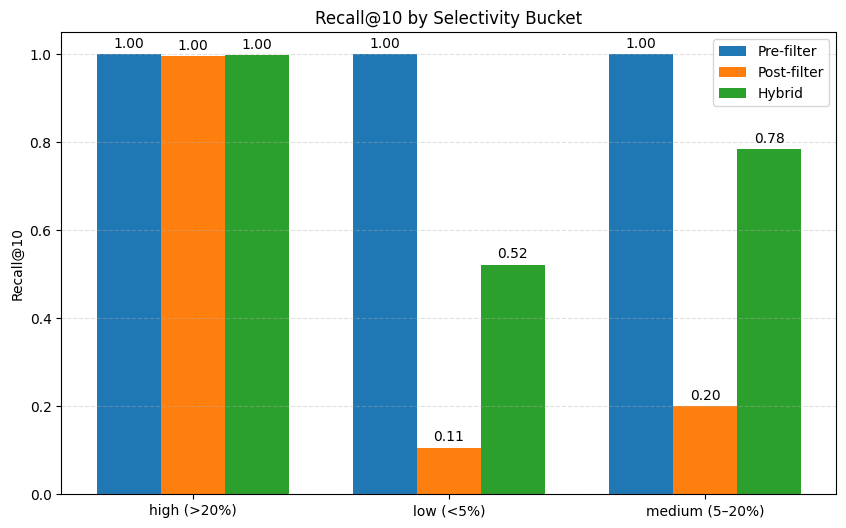

In [173]:
import matplotlib.pyplot as plt
import numpy as np

df = selectivity_metrics.copy()

buckets = df.index.tolist()
x = np.arange(len(buckets))
w = 0.25

plt.figure(figsize=(10,6))

plt.bar(x - w, df["pre_recall"], width=w, label="Pre-filter")
plt.bar(x, df["post_recall"], width=w, label="Post-filter")
plt.bar(x + w, df["hybrid_recall"], width=w, label="Hybrid")

plt.xticks(x, buckets)
plt.ylabel("Recall@10")
plt.title("Recall@10 by Selectivity Bucket")

# Add value labels
for i, bucket in enumerate(buckets):
    plt.text(x[i] - w, df["pre_recall"][i] + 0.015, f"{df['pre_recall'][i]:.2f}", ha="center")
    plt.text(x[i], df["post_recall"][i] + 0.015, f"{df['post_recall'][i]:.2f}", ha="center")
    plt.text(x[i] + w, df["hybrid_recall"][i] + 0.015, f"{df['hybrid_recall'][i]:.2f}", ha="center")

plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.show()


/var/folders/pg/pdr_0mlj0s1c13fzhzr0gjk40000gn/T/ipykernel_2098/4276762860.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] - w, df["pre_latency_ms"][i] + 0.5, f"{df['pre_latency_ms'][i]:.1f}", ha="center")
/var/folders/pg/pdr_0mlj0s1c13fzhzr0gjk40000gn/T/ipykernel_2098/4276762860.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i], df["post_latency_ms"][i] + 0.5, f"{df['post_latency_ms'][i]:.1f}", ha="center")
/var/folders/pg/pdr_0mlj0s1c13fzhzr0gjk40000gn/T/ipykernel_2098/4276762860.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

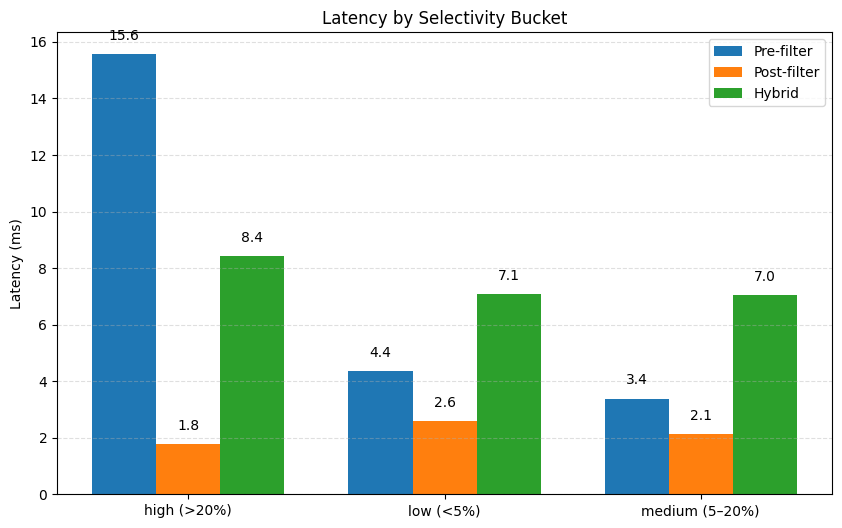

In [174]:
plt.figure(figsize=(10,6))

plt.bar(x - w, df["pre_latency_ms"], width=w, label="Pre-filter")
plt.bar(x, df["post_latency_ms"], width=w, label="Post-filter")
plt.bar(x + w, df["hybrid_latency_ms"], width=w, label="Hybrid")

plt.xticks(x, buckets)
plt.ylabel("Latency (ms)")
plt.title("Latency by Selectivity Bucket")

# Value labels
for i, bucket in enumerate(buckets):
    plt.text(x[i] - w, df["pre_latency_ms"][i] + 0.5, f"{df['pre_latency_ms'][i]:.1f}", ha="center")
    plt.text(x[i], df["post_latency_ms"][i] + 0.5, f"{df['post_latency_ms'][i]:.1f}", ha="center")
    plt.text(x[i] + w, df["hybrid_latency_ms"][i] + 0.5, f"{df['hybrid_latency_ms'][i]:.1f}", ha="center")

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.show()


In [169]:
import numpy as np
import pandas as pd
import time
import json

# nprobe sweep values
NP_values = [5, 10, 20, 30, 50, 75, 100, 150]
K = 10   # default K for evaluation

results_nprobe = []

print("\n=== Running hybrid search across nprobe values ===")

for nprobe in NP_values:
    print(f"\n--- Evaluating nprobe = {nprobe} ---")

    recalls = []
    latencies = []

    for q in workload:
        qid = q["query_id"]
        filt = q["filters"]

        query_vec = embeddings[qid:qid+1]

        # Ground truth for filtered subset
        valid_idx = metadata_filter.get_valid_indices(filt)

        if len(valid_idx) == 0:
            gt_idx = np.full(K, -1)
        else:
            valid_embs = embeddings[valid_idx]
            d = np.linalg.norm(valid_embs - query_vec, axis=1)
            top = np.argsort(d)[:K]
            gt_idx = np.array(valid_idx)[top]

        # Hybrid search call
        D_h, I_h, stats_h = hybrid_searcher.search_with_predicate_pushdown(
            query_vec, K, filt, nprobe=nprobe
        )

        # compute recall
        pred = set(I_h[:K]) - {-1}
        truth = set(gt_idx[:K]) - {-1}
        if len(truth) == 0:
            recall = 1.0
        else:
            recall = len(pred & truth) / len(truth)

        recalls.append(recall)
        latencies.append(stats_h["latency"] * 1000)  # ms

    # Store results
    results_nprobe.append({
        "nprobe": nprobe,
        "recall": np.mean(recalls),
        "latency_ms": np.mean(latencies)
    })

# Convert to DataFrame
df_nprobe = pd.DataFrame(results_nprobe)
df_nprobe.to_csv("data/results_hybrid_nprobe_summary.csv", index=False)

print("\nSaved results → data/results_hybrid_nprobe_summary.csv")
print(df_nprobe)



=== Running hybrid search across nprobe values ===

--- Evaluating nprobe = 5 ---

--- Evaluating nprobe = 10 ---

--- Evaluating nprobe = 20 ---

--- Evaluating nprobe = 30 ---

--- Evaluating nprobe = 50 ---

--- Evaluating nprobe = 75 ---

--- Evaluating nprobe = 100 ---

--- Evaluating nprobe = 150 ---

Saved results → data/results_hybrid_nprobe_summary.csv
   nprobe    recall  latency_ms
0       5  0.763333    8.238023
1      10  0.835333    7.900335
2      20  0.884667    7.860335
3      30  0.910667    8.484613
4      50  0.931333   10.137944
5      75  0.958667   10.992769
6     100  0.978667   12.256842
7     150  1.000000   14.883521


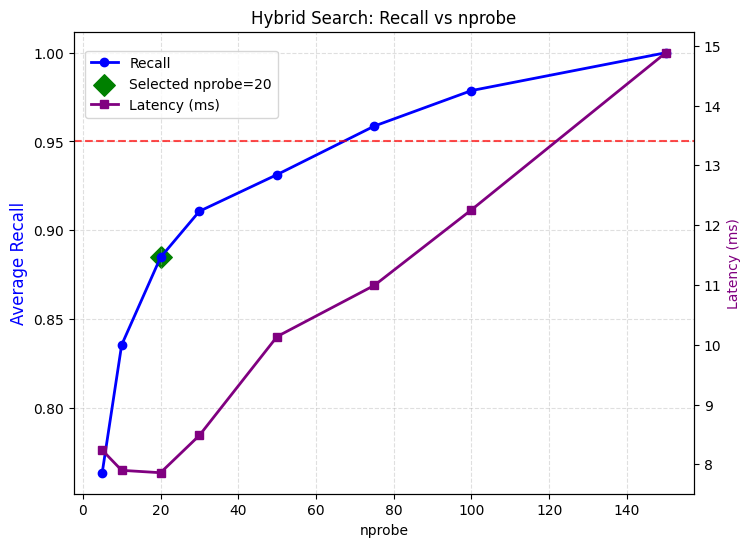

In [170]:
import matplotlib.pyplot as plt

df_nprobe = pd.read_csv("data/results_hybrid_nprobe_summary.csv")

fig, ax1 = plt.subplots(figsize=(8,6))

# Recall curve
ax1.plot(df_nprobe["nprobe"], df_nprobe["recall"], marker="o",
         label="Recall", color="blue", linewidth=2)
ax1.set_xlabel("nprobe")
ax1.set_ylabel("Average Recall", color="blue", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.4)

# 95% ideal recall
ax1.axhline(0.95, linestyle="--", color="red", alpha=0.7)

# Mark selected nprobe=20 (optional)
if 20 in df_nprobe["nprobe"].values:
    sel = df_nprobe[df_nprobe["nprobe"] == 20].iloc[0]
    ax1.scatter(sel["nprobe"], sel["recall"], color="green", s=120, marker="D",
                label="Selected nprobe=20")

# Latency curve
ax2 = ax1.twinx()
ax2.plot(df_nprobe["nprobe"], df_nprobe["latency_ms"], marker="s",
         color="purple", linewidth=2, label="Latency (ms)")
ax2.set_ylabel("Latency (ms)", color="purple")

plt.title("Hybrid Search: Recall vs nprobe")
fig.legend(loc="upper left", bbox_to_anchor=(0.13,0.86))
plt.show()


In [154]:
import pandas as pd
import numpy as np
import json
import time

# --------------------------------------------------------------
# K values to evaluate
# --------------------------------------------------------------
K_values = [5, 10, 20, 50]
NPROBE = 50  # same nprobe you used before

multi_results = []

print(f"\n=== Running Hybrid Evaluation for K = {K_values} ===")

for K in K_values:
    print(f"\n--- Evaluating K = {K} ---")

    for q in workload:
        qid = q["query_id"]
        filt = q["filters"]

        query_vec = embeddings[qid:qid+1]

        # ----------------------------------------------------------
        # Ground truth for this K (brute force over filtered subset)
        # ----------------------------------------------------------
        valid_idx = metadata_filter.get_valid_indices(filt)
        valid_embs = embeddings[valid_idx]

        if len(valid_idx) == 0:
            D_true = np.full(K, float('inf'))
            I_true = np.full(K, -1)
        else:
            dist = np.linalg.norm(valid_embs - query_vec, axis=1)

            if len(dist) >= K:
                top_k = np.argpartition(dist, K)[:K]
                top_k = top_k[np.argsort(dist[top_k])]
            else:
                top_k = np.arange(len(dist))

            D_true = dist[top_k]
            I_true = np.array(valid_idx)[top_k]

        # ----------------------------------------------------------
        # Hybrid Search (Predicate Pushdown)
        # ----------------------------------------------------------
        D_h, I_h, stats_h = hybrid_searcher.search_with_predicate_pushdown(
            query_vec,
            k=K,
            filter_conditions=filt,
            nprobe=NPROBE
        )

        # Compute recall@K
        def recall_at_k(pred, gt, k):
            pred_set = set([p for p in pred[:k] if p >= 0])
            gt_set = set([g for g in gt[:k] if g >= 0])
            if len(gt_set) == 0:
                return 1.0 if len(pred_set) == 0 else 0.0
            return len(pred_set & gt_set) / len(gt_set)

        recall_h = recall_at_k(I_h, I_true, K)

        sel = len(valid_idx) / len(embeddings)

        # Store results
        multi_results.append({
            "K": K,
            "query_id": qid,
            "filters": json.dumps(filt),
            "selectivity": sel,

            "recall_hybrid": recall_h,
            "latency_hybrid": stats_h["latency"],

            "clusters_probed": stats_h["clusters_probed"],
            "clusters_skipped": stats_h["clusters_skipped"],
            "distance_computations": stats_h["distance_computations"]
        })

# --------------------------------------------------------------
# Save results
# --------------------------------------------------------------
multi_df = pd.DataFrame(multi_results)
multi_df.to_csv("data/results_hybrid_multiK.csv", index=False)

print("\nSaved multi-K hybrid results → data/results_hybrid_multiK.csv")
print(multi_df.head())



=== Running Hybrid Evaluation for K = [5, 10, 20, 50] ===

--- Evaluating K = 5 ---

--- Evaluating K = 10 ---

--- Evaluating K = 20 ---

--- Evaluating K = 50 ---

Saved multi-K hybrid results → data/results_hybrid_multiK.csv
   K  query_id                                          filters  selectivity  \
0  5    128060  {"year": [2006, 2007], "explicit": 0, "key": 6}     0.044223   
1  5     77384            {"year": [1964, 1966], "explicit": 0}     0.915082   
2  5    105260            {"year": [2004, 2005], "explicit": 1}     0.084918   
3  5     42918  {"year": [1981, 1983], "explicit": 0, "key": 8}     0.057317   
4  5     24661            {"year": [2007, 2008], "explicit": 0}     0.915082   

   recall_hybrid  latency_hybrid  clusters_probed  clusters_skipped  \
0            0.0        0.013933                4               146   
1            1.0        0.013795               50                 0   
2            1.0        0.006156               50                 1   
3     

In [155]:
import pandas as pd

# Load multi-K results
df = pd.read_csv("data/results_hybrid_multiK.csv")

# Compute summary statistics per K
summary = df.groupby("K").agg({
    "recall_hybrid": "mean",
    "latency_hybrid": "mean",
    "selectivity": "mean",
    "clusters_probed": "mean",
    "clusters_skipped": "mean",
    "distance_computations": "mean"
}).reset_index()

# Rename columns for clarity
summary = summary.rename(columns={
    "recall_hybrid": "mean_recall",
    "latency_hybrid": "mean_latency",
    "selectivity": "mean_selectivity",
    "clusters_probed": "mean_clusters_probed",
    "clusters_skipped": "mean_clusters_skipped",
    "distance_computations": "mean_distance_computations"
})

# Save summary CSV
summary.to_csv("data/results_hybrid_multiK_summary.csv", index=False)

print("Saved mean summary → data/results_hybrid_multiK_summary.csv")
print(summary)


Saved mean summary → data/results_hybrid_multiK_summary.csv
    K  mean_recall  mean_latency  mean_selectivity  mean_clusters_probed  \
0   5     0.936000      0.008954          0.633985             44.746667   
1  10     0.931333      0.009962          0.633985             44.746667   
2  20     0.928667      0.010863          0.633985             44.746667   
3  50     0.919200      0.012379          0.633985             44.806667   

   mean_clusters_skipped  mean_distance_computations  
0              26.993333                14347.360000  
1              26.993333                14347.360000  
2              26.993333                14347.360000  
3              27.020000                14347.693333  
